总样本数: 8732
      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


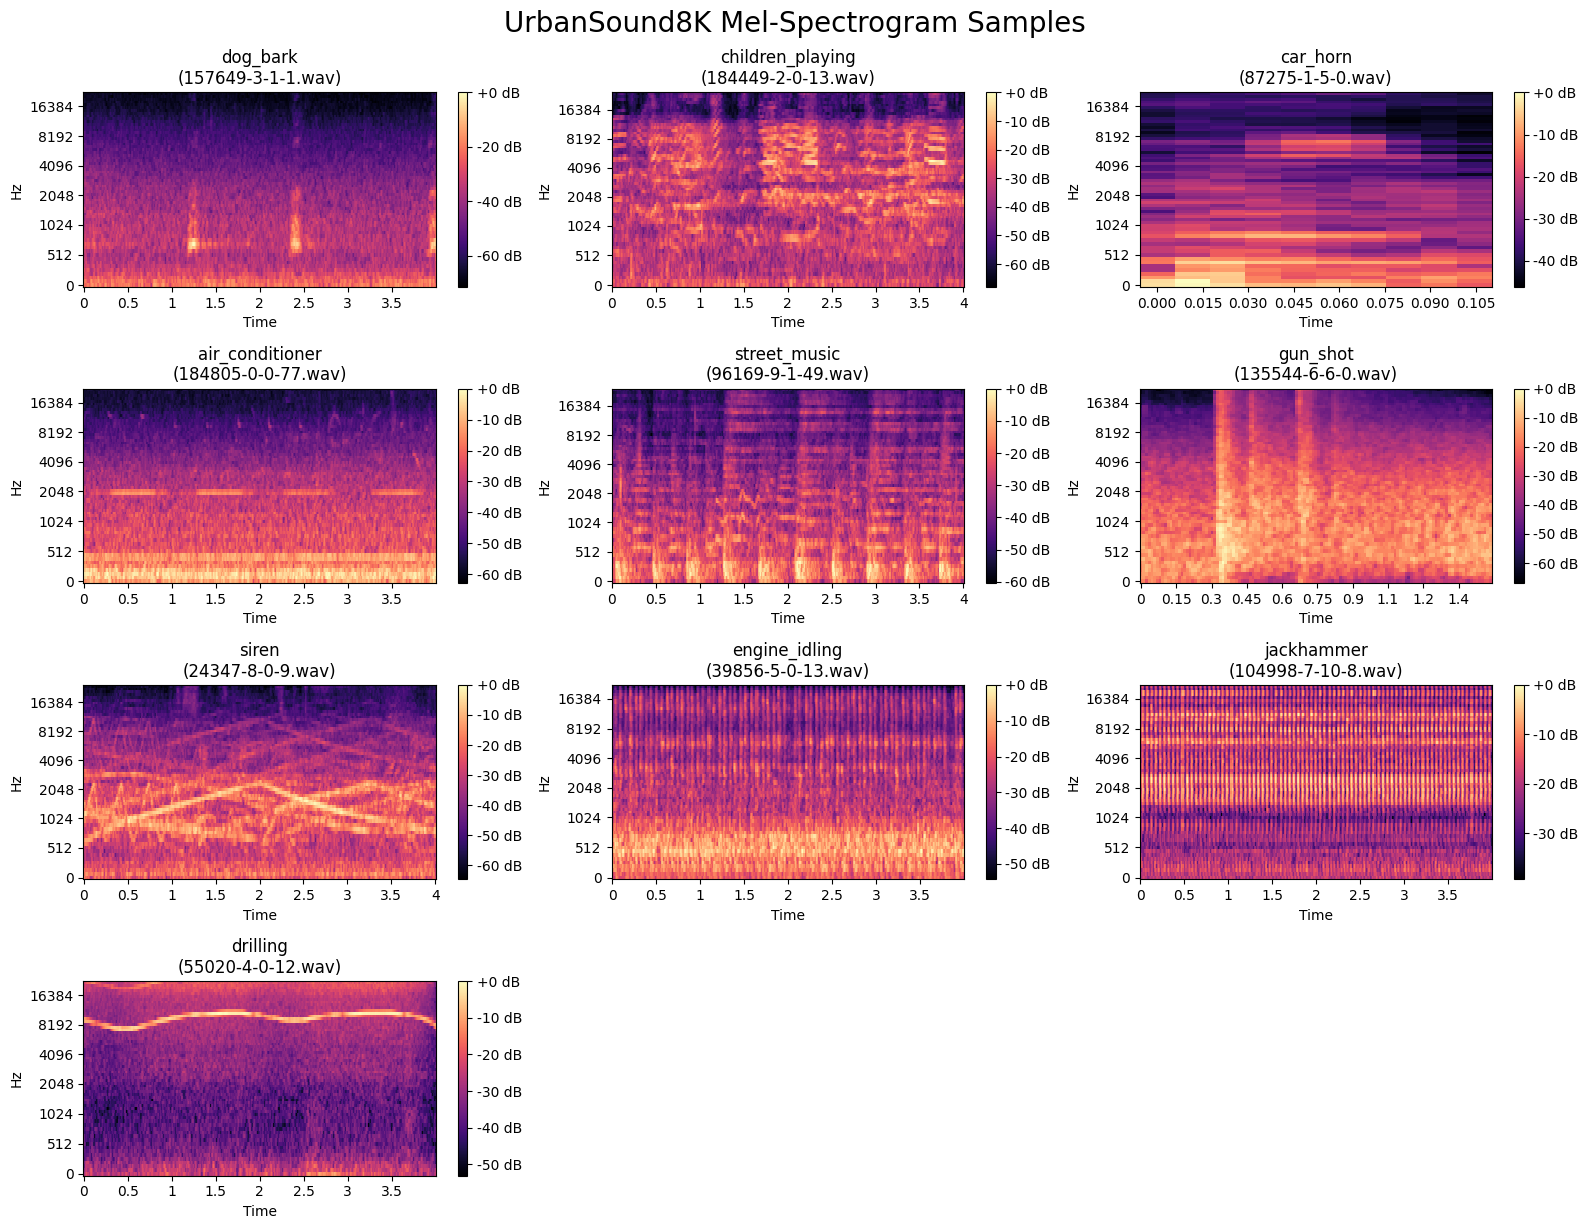

In [1]:
import os
import torch
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import soundfile as sf
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import sys, platform
from pathlib import Path
import random


# === 数据路径 ===
AUDIO_DIR = "/projectnb/cs599m1/students/zu55518/datasets/datasets/urbansound8k/1.0.0/build/audio"
META_FILE = "/projectnb/cs599m1/students/zu55518/datasets/datasets/urbansound8k/1.0.0/metadata/UrbanSound8K.csv"

# === 读取元数据 ===
df = pd.read_csv(META_FILE)
print("总样本数:", len(df))
print(df.head())

# === 从每一类随机挑一个样本 ===
classes = df["class"].unique()
n_classes = len(classes)

plt.figure(figsize=(16, 12))
for i, c in enumerate(classes[:10]):
    # 从该类挑一条
    row = df[df["class"] == c].sample(1).iloc[0]
    wav_path = os.path.join(AUDIO_DIR, f"fold{row.fold}", row.slice_file_name)

    # 读音频
    y, sr = librosa.load(wav_path, sr=None)

    # 转为 Mel-spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # 绘图
    plt.subplot(4, 3, i + 1)
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
    plt.title(f"{c}\n({row.slice_file_name})")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

plt.suptitle("UrbanSound8K Mel-Spectrogram Samples", fontsize=20, y=1.02)
plt.show()


/scratch/1059609.1.academic-gpu/ipykernel_2302676/1041681312.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="class", order=df["class"].value_counts().index, palette="viridis")


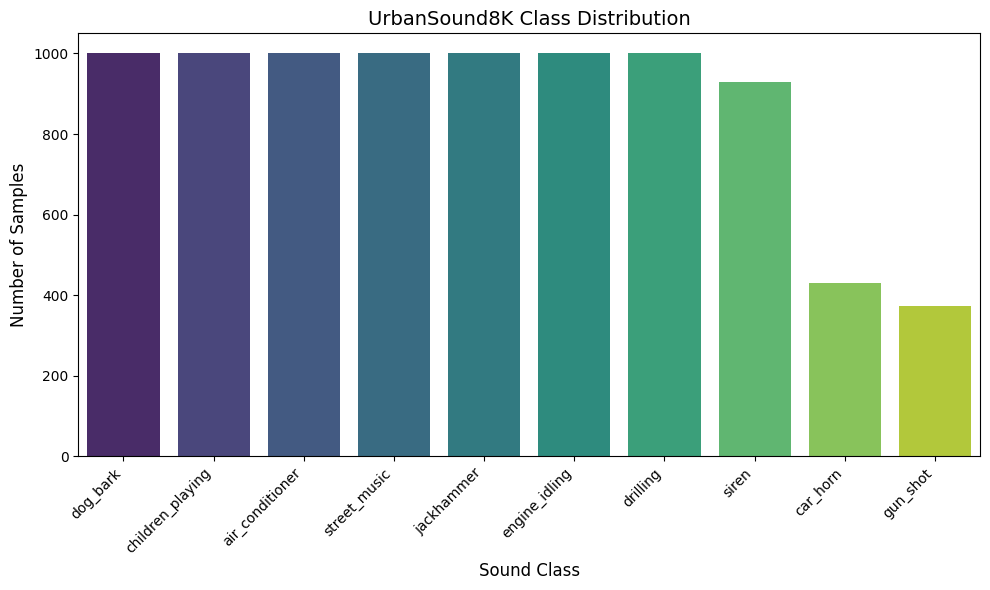

In [2]:
# ---------- 绘制类别分布 ----------
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(data=df, x="class", order=df["class"].value_counts().index, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("UrbanSound8K Class Distribution", fontsize=14)
plt.xlabel("Sound Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.tight_layout()

# 保存为 README 用图
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/class_distribution.png", dpi=300)
plt.show()


In [3]:
# 训练超参
CFG = {
    "epochs": 25,
    "batch_size": 32,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "sample_rate": None,  
    "n_mels": 64,           
    "n_fft": 1024,
    "fixed_seconds": 4.0,
    "hop_length": 512,
    "fmax": 8000,          
    "num_workers": 2,
    "seed":42
}

CFG


{'epochs': 25,
 'batch_size': 32,
 'lr': 0.001,
 'weight_decay': 0.0001,
 'sample_rate': None,
 'n_mels': 64,
 'n_fft': 1024,
 'fixed_seconds': 4.0,
 'hop_length': 512,
 'fmax': 8000,
 'num_workers': 2,
 'seed': 42}

In [4]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True  # True: 更快

set_seed(CFG["seed"])
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
df = pd.read_csv(META_FILE)
print("SAMPLE NUMBER:", len(df))
classes = sorted(df["class"].unique().tolist())
class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}
classes, class_to_idx


SAMPLE NUMBER: 8732


(['air_conditioner',
  'car_horn',
  'children_playing',
  'dog_bark',
  'drilling',
  'engine_idling',
  'gun_shot',
  'jackhammer',
  'siren',
  'street_music'],
 {'air_conditioner': 0,
  'car_horn': 1,
  'children_playing': 2,
  'dog_bark': 3,
  'drilling': 4,
  'engine_idling': 5,
  'gun_shot': 6,
  'jackhammer': 7,
  'siren': 8,
  'street_music': 9})

In [6]:
def wav_to_logmel(y, sr, n_mels, n_fft, hop_length, fmax):
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmax=fmax
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db  # (n_mels, T)

def pad_or_crop_time(x, T):
    # x:(n_mels, t), 让时间维到 T（右侧补零/裁剪）
    if x.shape[1] == T:
        return x
    if x.shape[1] > T:
        return x[:, :T]
    pad = T - x.shape[1]
    return np.pad(x, ((0,0), (0,pad)), mode="constant", constant_values=x.min())

# 计算固定帧数（基于 4s & hop_length）
def frames_for_seconds(seconds, hop_length, sr):
    return int(np.ceil(seconds * sr / hop_length))

# 如果不重采样，用“典型 sr = 48000”估计 T_fixed；不同 sr 会有细微差异，我们再 pad/crop
T_fixed = frames_for_seconds(CFG["fixed_seconds"], CFG["hop_length"], 48000)
T_fixed


375

In [7]:
class UrbanSoundMel(Dataset):
    def __init__(self, df, audio_dir, folds, cfg, class_to_idx):
        # 选择对应的 fold
        self.df = df[df["fold"].isin(folds)].reset_index(drop=True)
        self.audio_dir = Path(audio_dir)
        self.cfg = cfg
        self.class_to_idx = class_to_idx
        self.n_mels = cfg["n_mels"]
        self.T_fixed = T_fixed

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        wav_path = self.audio_dir / f"fold{row.fold}" / row.slice_file_name

        # ---------- 读取音频 ----------
        y, sr = sf.read(wav_path)  # 用 soundfile 读取更快

        # 若需要统一采样率则重采样
        if self.cfg["sample_rate"]:
            if sr != self.cfg["sample_rate"]:
                y = librosa.resample(y, orig_sr=sr, target_sr=self.cfg["sample_rate"])
                sr = self.cfg["sample_rate"]

        # 双声道 -> 单声道
        if y.ndim == 2:
            y = y.mean(axis=1)

        # ---------- 生成 Mel-spectrogram ----------
        mel_db = wav_to_logmel(
            y, sr,
            self.cfg["n_mels"], self.cfg["n_fft"],
            self.cfg["hop_length"], self.cfg["fmax"]
        )  # (n_mels, T)

        # ---------- 归一化 & 固定长度 ----------
        mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)
        mel_fixed = pad_or_crop_time(mel_db, self.T_fixed)

        # ---------- 转为 Tensor ----------
        x = torch.tensor(mel_fixed, dtype=torch.float32).unsqueeze(0)  # (1, n_mels, T)
        y_label = torch.tensor(self.class_to_idx[row["class"]], dtype=torch.long)
        return x, y_label, str(wav_path)


# ---------- 官方三分法 ----------
# 每个 fold 都包含全部 10 类，只是来源不同
train_folds = [1,2,3,4,5,6,7,8]  # 训练
val_folds   = [9]                # 验证
test_folds  = [10]               # 测试

train_ds = UrbanSoundMel(df, AUDIO_DIR, train_folds, CFG, class_to_idx)
val_ds   = UrbanSoundMel(df, AUDIO_DIR, val_folds,   CFG, class_to_idx)
test_ds  = UrbanSoundMel(df, AUDIO_DIR, test_folds,  CFG, class_to_idx)

print(f"Train: {len(train_ds)} samples | Val: {len(val_ds)} | Test: {len(test_ds)}")


Train: 7079 samples | Val: 816 | Test: 837


In [8]:
class SmallCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2),  # (n_mels/2, T/2)

            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # /4

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # /8
        )
        # 计算展平后的特征尺寸（动态）
        with torch.no_grad():
            dummy = torch.zeros(1, 1, CFG["n_mels"], T_fixed)
            out = self.features(dummy)
            self.flat_dim = out.numel()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flat_dim, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SmallCnn(n_classes=len(classes)).to(device)
sum(p.numel() for p in model.parameters())/1e6, model.__class__.__name__


(6.055658, 'SmallCnn')

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_ds,
    batch_size=CFG["batch_size"],
    shuffle=True,
    num_workers=CFG["num_workers"],
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=CFG["batch_size"],
    shuffle=False,
    num_workers=CFG["num_workers"],
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=CFG["batch_size"],
    shuffle=False,
    num_workers=CFG["num_workers"],
    pin_memory=True
)

print(f"✅ DataLoaders ready — train:{len(train_loader)} batches, val:{len(val_loader)}, test:{len(test_loader)}")


✅ DataLoaders ready — train:222 batches, val:26, test:27


In [10]:
from torch.cuda.amp import autocast, GradScaler
import time
from torch.amp import GradScaler
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG["epochs"])
scaler = GradScaler("cuda", enabled=(device=="cuda"))
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
best_path = "best_us8k_cnn.pt"

def run_one_epoch(loader, training=True):
    model.train(training)
    tot_loss, y_true, y_pred = 0.0, [], []
    for x, y, _ in loader:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        with torch.set_grad_enabled(training):
            with autocast(enabled=(device=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            if training:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
        tot_loss += loss.item() * x.size(0)
        y_true.extend(y.detach().cpu().tolist())
        y_pred.extend(logits.argmax(1).detach().cpu().tolist())
    avg_loss = tot_loss / len(loader.dataset)
    acc = accuracy_score(y_true, y_pred)
    return avg_loss, acc

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

for epoch in range(1, CFG["epochs"]+1):
    t0 = time.time()
    tr_loss, tr_acc = run_one_epoch(train_loader, training=True)
    val_loss, val_acc = run_one_epoch(val_loader, training=False)
    scheduler.step()

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model": model.state_dict(),
                    "cfg": CFG,
                    "classes": classes}, best_path)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss);   history["val_acc"].append(val_acc)

    print(f"[{epoch:02d}/{CFG['epochs']}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.3f} | "
          f"best_val_acc={best_acc:.3f} | "
          f"{time.time()-t0:.1f}s")


[01/25] train_loss=2.4593 acc=0.341 | val_loss=1.4885 acc=0.458 | best_val_acc=0.458 | 124.5s
[02/25] train_loss=1.4468 acc=0.469 | val_loss=1.3492 acc=0.504 | best_val_acc=0.504 | 35.4s
[03/25] train_loss=1.2639 acc=0.531 | val_loss=1.3350 acc=0.597 | best_val_acc=0.597 | 36.0s
[04/25] train_loss=1.1105 acc=0.598 | val_loss=1.5340 acc=0.619 | best_val_acc=0.619 | 35.8s
[05/25] train_loss=0.9647 acc=0.648 | val_loss=1.2775 acc=0.626 | best_val_acc=0.626 | 35.7s
[06/25] train_loss=0.8581 acc=0.697 | val_loss=1.4860 acc=0.583 | best_val_acc=0.626 | 35.5s
[07/25] train_loss=0.7823 acc=0.717 | val_loss=1.1835 acc=0.637 | best_val_acc=0.637 | 33.3s
[08/25] train_loss=0.6812 acc=0.754 | val_loss=1.2650 acc=0.630 | best_val_acc=0.637 | 35.0s
[09/25] train_loss=0.5943 acc=0.782 | val_loss=1.1717 acc=0.690 | best_val_acc=0.690 | 35.3s
[10/25] train_loss=0.5307 acc=0.805 | val_loss=1.2137 acc=0.705 | best_val_acc=0.705 | 35.9s
[11/25] train_loss=0.4686 acc=0.824 | val_loss=1.2818 acc=0.684 | bes

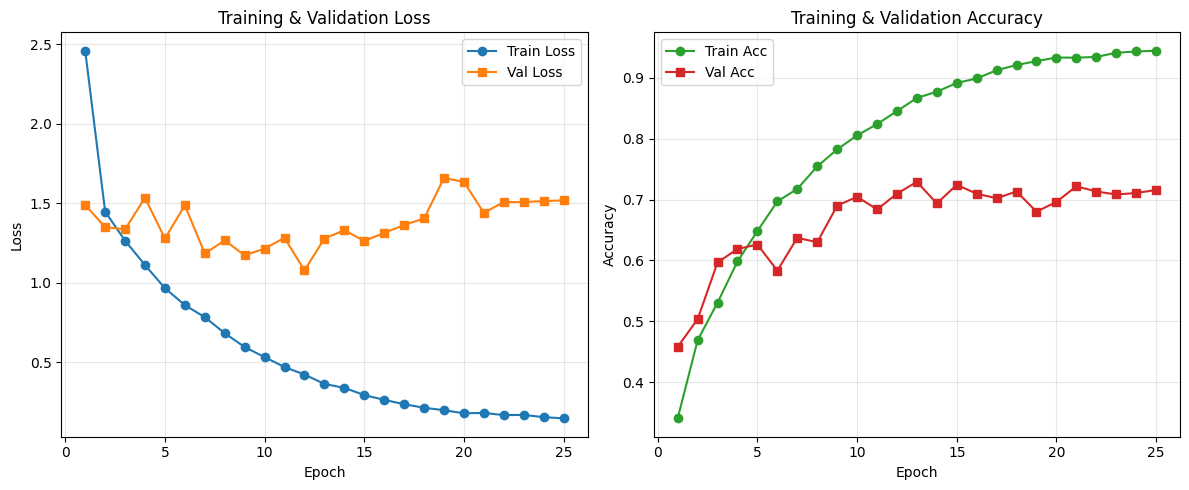

In [11]:
# ---------- 绘制训练曲线 ----------
import matplotlib.pyplot as plt
import os

# 提取训练结果
train_losses = history["train_loss"]
val_losses   = history["val_loss"]
train_accs   = history["train_acc"]
val_accs     = history["val_acc"]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

# --- Loss 曲线 ---
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o', color='tab:blue')
plt.plot(epochs, val_losses, label="Val Loss", marker='s', color='tab:orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(alpha=0.3)

# --- Accuracy 曲线 ---
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train Acc", marker='o', color='tab:green')
plt.plot(epochs, val_accs, label="Val Acc", marker='s', color='tab:red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()

# 保存图像
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/training_curve.png", dpi=300)
plt.show()


In [12]:
from sklearn.metrics import classification_report

# 加载最佳模型
state = torch.load(best_path, map_location=device)
model.load_state_dict(state["model"])
model.to(device)
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x, y, _ in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        y_true.extend(y.cpu().tolist())
        y_pred.extend(logits.argmax(1).cpu().tolist())

print("Test Report：")
print(classification_report(y_true, y_pred, target_names=list(class_to_idx.keys()), digits=4))


Test Report：
                  precision    recall  f1-score   support

 air_conditioner     0.8767    0.6400    0.7399       100
        car_horn     0.9677    0.9091    0.9375        33
children_playing     0.4465    0.7100    0.5483       100
        dog_bark     0.7640    0.6800    0.7196       100
        drilling     0.4061    0.8000    0.5387       100
   engine_idling     0.7468    0.6344    0.6860        93
        gun_shot     1.0000    0.9688    0.9841        32
      jackhammer     0.4146    0.1771    0.2482        96
           siren     0.8333    0.5422    0.6569        83
    street_music     0.8072    0.6700    0.7322       100

        accuracy                         0.6356       837
       macro avg     0.7263    0.6732    0.6791       837
    weighted avg     0.6839    0.6356    0.6361       837



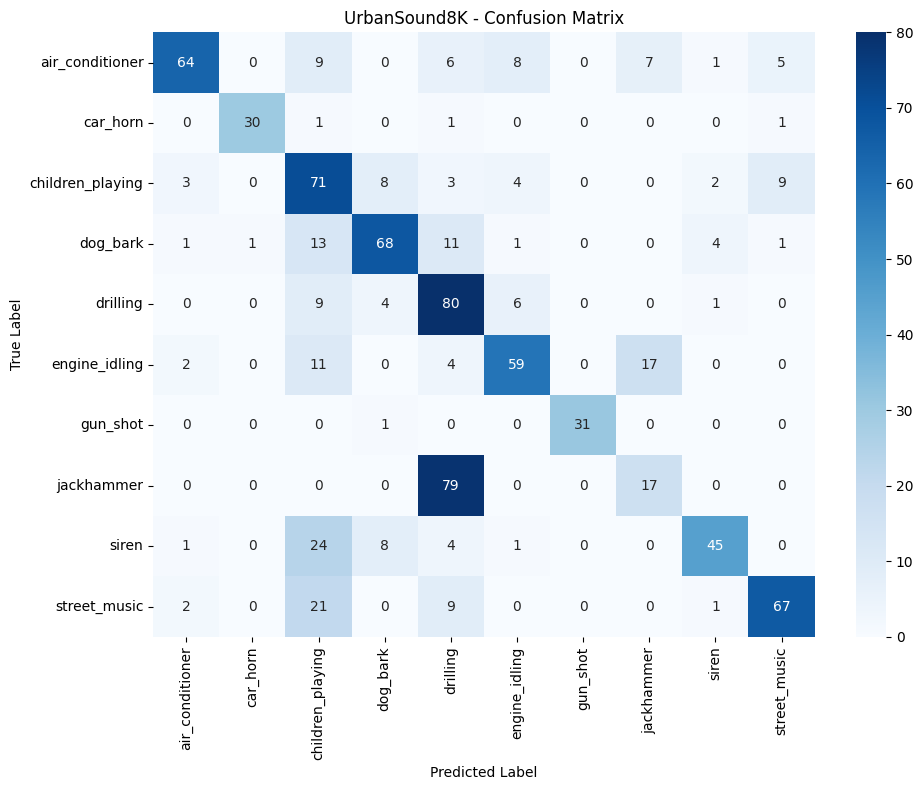

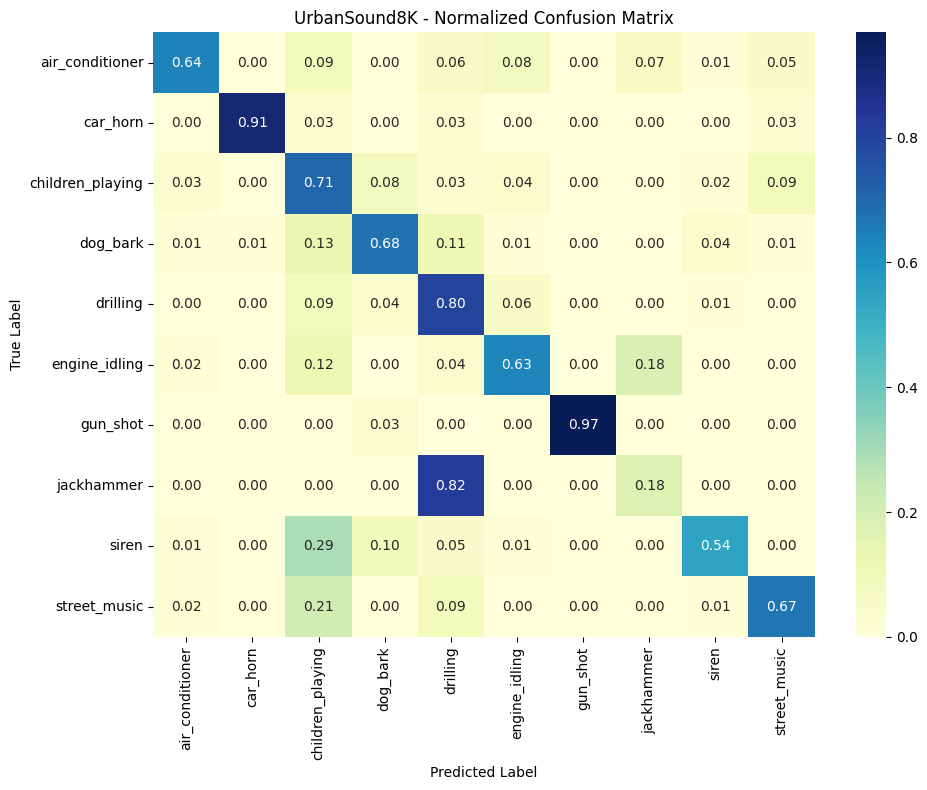

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# ---------- 混淆矩阵 ----------
cm = confusion_matrix(y_true, y_pred)
classes = list(class_to_idx.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("UrbanSound8K - Confusion Matrix")
plt.tight_layout()
plt.show()

# ---------- 归一化版本（百分比） ----------
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("UrbanSound8K - Normalized Confusion Matrix")
plt.tight_layout()
plt.show()
